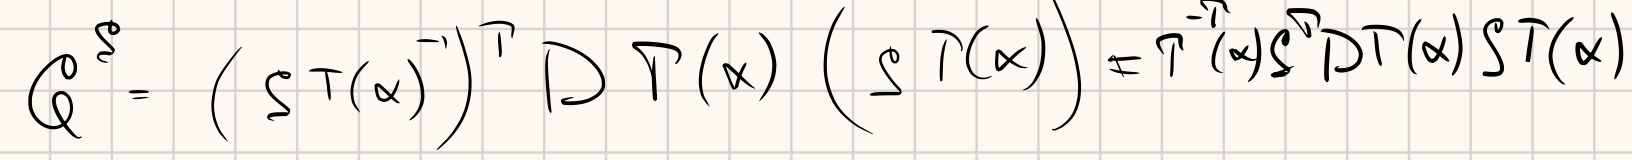

In [1]:
from itertools import product
import time 
import numpy as np

def _calculateQUBO (Q : np.ndarray, state_vector : np.ndarray):
        '''Calcs QUBO form's value by given [0,1] bitvector

        Parameters
        ----------
        Q : np.ndarray 
            QUBO form 
        state_vector : np.ndarray 
            bitvector
        Returns
        -------
        val : float
            QUBO form's value
        '''
        val = 0.5 * state_vector.T @ Q @ state_vector 
        return val

def checkQUBO (Q : np.ndarray): 
        '''
        Solve QUBO form using bruteforce
        
        Parameters 
        ----------
        Q : np.ndarray 
            ising matrix 
        Returns
        -------
        min_val : float 
            minimum energy 
        sol_states : list[np.ndarray]
            a list of optimal bitvectors
        end - start : float 
            time the bruteforce took
        '''

        start = time.time()
        min_val = 1e9
        sol_states = []
        dim = Q.shape[0]

        #with tqdm.tqdm(total = 2 * dim, desc="Brute forcing Ising QUBO") as pbar:
        for bits in product([0, 1], repeat = dim):
            bits = np.array(bits)
            val = _calculateQUBO(Q,bits)
            if (val < min_val): 
                min_val = val
            #pbar.update(1)
        
        for bits in product([0, 1], repeat = dim):
            bits = np.array(bits)
            val = _calculateQUBO(Q, bits) 
            if (val == min_val): 
                sol_states.append(bits)

            #pbar.update(1)
        
        end = time.time()
        
        return min_val, sol_states, end - start

In [263]:
from preparator import Preparator 
import numpy as np 
import pandas as pd 
from tqdm import tqdm
prep = Preparator()

newsols = [] 
oldsols = [] 
newstates = []
oldstates = [] 
newstiffs = []
oldstiffs = []

size = 16
low = 1e1 
high = 1e4
alpha = 1000

path = f'data/stiffness_generation_test/Generation_size_{size}_stiffs_{low}_to_{high}_alpha_{alpha}.csv'


for _ in tqdm(range(500), desc = 'Testing stiffness boost'):

    oldstiffness = np.random.randint(low = low, high = high)
    Q = prep.stiffnessPreparator(size = size, stiffness = oldstiffness)


    #print(f'generated stiffness {np.max(np.abs(np.linalg.eigvals(Q))) / np.min(np.abs(np.linalg.eigvals(Q)))}')

    S = np.linalg.eig(Q)[1].T


    stiffed_diag = np.linalg.eigvals(Q)
    mini = 0 
    maxi = 0

    for i in range (len(stiffed_diag)): 

        if (np.allclose(np.abs(stiffed_diag[i]),np.max(np.abs(stiffed_diag)))):
            maxi = i
            stiffed_diag[i] *= alpha 
        if (np.allclose(np.abs(stiffed_diag[i]),np.min(np.abs(stiffed_diag)))):
            mini = i
            stiffed_diag[i] /= alpha


    D = np.diag(stiffed_diag)

    T = np.diag([1.0] * S.shape[0])

    T[mini,mini] = T[mini,mini] / np.sqrt(alpha)
    T[maxi, maxi] = T[maxi,maxi] * np.sqrt(alpha) 

    #print(f'T : {T}')

    Ss = np.linalg.inv(S) @ T
    #print (mini, maxi)

    #print(f'S : {S} | D : {D}')

    #print(T)

    #Qs = np.linalg.inv(Ss).T @ D @ T @ T @ np.linalg.inv(Ss) / alpha
    Qs = S.T @ D @ S / alpha
    eigQs = np.abs(np.linalg.eigvals(Qs)) 

    
    oldsoldata = checkQUBO(Q) 
    newsoldata = checkQUBO(Qs) 


    newsol = newsoldata[0]
    oldsol = oldsoldata[0]
    newstate = newsoldata[1] 
    oldstate = oldsoldata[1] 
    newstiffness = max(eigQs) / min(eigQs)

    newsols.append(newsol)
    oldsols.append(oldsol)
    newstates.append(np.array(newstate).tolist()[0])
    oldstates.append(np.array(oldstate).tolist()[0])
    oldstiffs.append(oldstiffness)
    newstiffs.append(newstiffness)


data = { 
    'Test_stiffness' : oldstiffs, 
    'Train_stiffness' :newstiffs, 
    'Test_sol' : oldsols, 
    'Train_sol' : newsols, 
    'Test_state' : oldstates, 
    'Train_state' : newstates
}


df = pd.DataFrame(data)
df.to_csv(path_or_buf = path.format(size = size, low = low, high = high, alpha = alpha), index = False)

Testing stiffness boost: 100%|██████████| 500/500 [1:03:28<00:00,  7.62s/it]


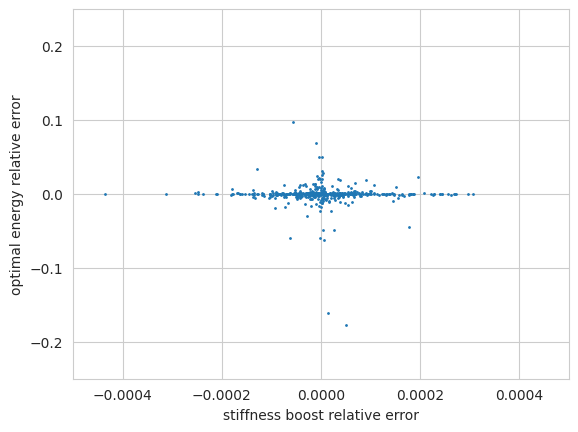

In [307]:

import seaborn as sns
from matplotlib import pyplot as plt

sns.set_style('whitegrid')

error = (df['Train_sol'] - df['Test_sol']) / df['Test_sol']
boost = ((df['Train_stiffness'] - df['Test_stiffness'] * alpha ** 2) / (df['Test_stiffness'] * alpha ))
plt.xlim(xmin = -0.0005, xmax = 0.0005)
plt.ylim(ymin = -0.25, ymax = 0.25)
plt.xlabel('stiffness boost relative error')
plt.ylabel('optimal energy relative error')
plt.scatter(boost, error, s = 1)

plt.show()